In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel

from scipy.integrate import quad
from scipy.interpolate import interp1d

from SyntheticDataModule import *
from estimators import *
from utils import *

RCT size: 500, OS size: 1000, time elapsed: 151.33


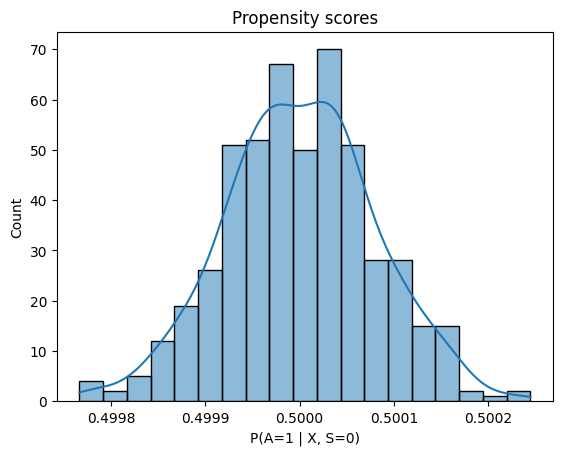

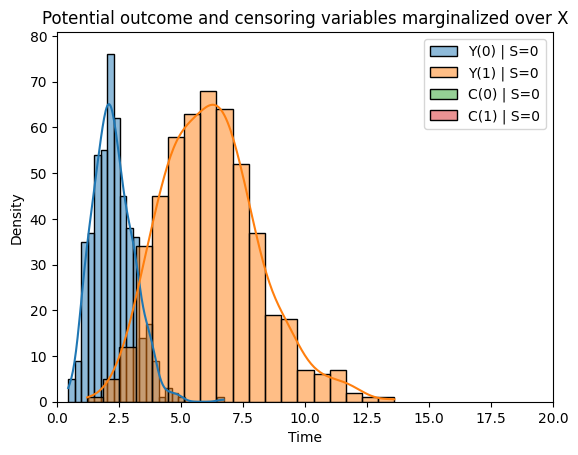

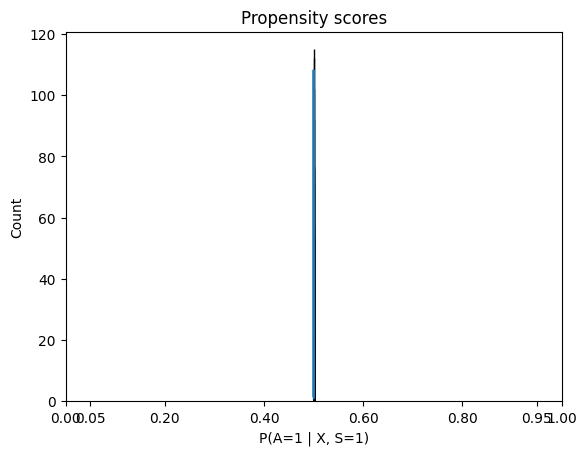

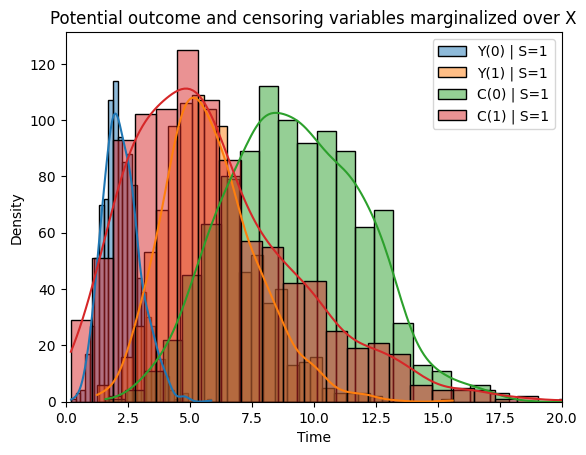

In [2]:
mmr_keys = ["IPCW", "CDR", "CDR-MissF", "CDR-MissG"]
CD = 10
UC = 0
jD = read_json('complete-IC/samePO-Copy1.json', CD, UC, mmr_keys)
m = 2
os_size = int(jD['rct_size'] * m)

t1 = time()

df_combined, df_comb_drop, RCTData, OSData = generate_data(CD, os_size, jD)
Fb_Y, Gb_C = fill_nuisance(df_combined, df_comb_drop, jD)

print('RCT size: {}, OS size: {}, time elapsed: {:.2f}'.format(jD['rct_size'], os_size, time() - t1))

summary_df = pd.concat([RCTData.summary(plot=True), OSData.summary(plot=True)], axis=0, ignore_index=True)
summary_df

crop_prop = True

mmr_stats = np.zeros((len(mmr_keys), 2))  # store results and p-val for each mmr test

for kind, key in enumerate(mmr_keys):
    if 'Drop' in key:
        df_mmr = df_comb_drop.copy()
    else:
        df_mmr = df_combined.copy()

    if jD['crop_prop'] and ('Drop' not in key):
        df_mmr = df_mmr[(0.05 < df_mmr['P(S=1|X)']) & (df_mmr['P(S=1|X)'] < 0.95) &\
                (0.05 < df_mmr['P(A=1|X,S)']) & (df_mmr['P(A=1|X,S)'] < 0.95) &\
                (0.05 < df_mmr['Gb(T|X,S,A)'])].copy().reset_index(drop=True)

    if jD['crop_prop'] and ('Drop' in key):
        df_mmr = df_mmr[(0.05 < df_mmr['P(S=1|X)']) & (df_mmr['P(S=1|X)'] < 0.95) &\
                (0.05 < df_mmr['P(A=1|X,S)']) & (df_mmr['P(A=1|X,S)'] < 0.95)].copy().reset_index(drop=True)

    signal0, signal1 = jD['test_signals'][key][0], jD['test_signals'][key][1]
    mmr_stats[kind, 0], mmr_stats[kind, 1] = mmr_test(df_mmr, jD['cov_list'], jD['B'], laplacian_kernel, signal0, signal1)

In [30]:
for s in range(2):
    for a in range(2):
        print('-----\n-----')
        df = df_combined.query(f"S == {s} & A == {a}").copy()  # all data
        df = df_mmr.query(f"S == {s} & A == {a}").copy()       # goes into MMR (after cropping etc.)

        Ystar_No_miss = f'S{s}_Ystar_Miss_None_est_CATE'
        Ystar_Fb_miss = f'S{s}_Ystar_Miss_Fb_est_CATE'
        Ystar_Gb_miss = f'S{s}_Ystar_Miss_Gb_est_CATE'
        
        mu_No_miss = f'S{s}_muxsa{a}_Miss_None_est_CATE'
        mu_Fb_miss = f'S{s}_muxsa{a}_Miss_Fb_est_CATE'
        mu_Gb_miss = f'S{s}_muxsa{a}_Miss_Gb_est_CATE'

        print("E[Y|S={}, A={}]: {:.2f}".format(s ,a, df[f'Y{a}'].mean()))
        print("E[Ystar_No_miss|S={}, A={}]: {:.2f}".format(s, a, df[Ystar_No_miss].mean()))
        print("E[Ystar_Fb_miss|S={}, A={}]: {:.2f}".format(s, a, df[Ystar_Fb_miss].mean()))
        print("E[Ystar_Gb_miss|S={}, A={}]: {:.2f}".format(s, a, df[Ystar_Gb_miss].mean()))
        print("E[mu_No_miss|S={}, A={}]: {:.2f}".format(s, a, df[mu_No_miss].mean()))
        print("E[mu_Fb_miss|S={}, A={}]: {:.2f}".format(s, a, df[mu_Fb_miss].mean()))
        print("E[mu_Gb_miss|S={}, A={}]: {:.2f}".format(s, a, df[mu_Gb_miss].mean()))

-----
-----
E[Y|S=0, A=0]: 2.28
E[Ystar_No_miss|S=0, A=0]: 2.28
E[Ystar_Fb_miss|S=0, A=0]: 2.28
E[Ystar_Gb_miss|S=0, A=0]: 2.28
E[mu_No_miss|S=0, A=0]: 2.21
E[mu_Fb_miss|S=0, A=0]: 2.21
E[mu_Gb_miss|S=0, A=0]: 2.21
-----
-----
E[Y|S=0, A=1]: 6.18
E[Ystar_No_miss|S=0, A=1]: 6.18
E[Ystar_Fb_miss|S=0, A=1]: 6.18
E[Ystar_Gb_miss|S=0, A=1]: 6.18
E[mu_No_miss|S=0, A=1]: 6.03
E[mu_Fb_miss|S=0, A=1]: 5.95
E[mu_Gb_miss|S=0, A=1]: 6.03
-----
-----
E[Y|S=1, A=0]: 2.30
E[Ystar_No_miss|S=1, A=0]: 2.30
E[Ystar_Fb_miss|S=1, A=0]: 2.30
E[Ystar_Gb_miss|S=1, A=0]: 2.30
E[mu_No_miss|S=1, A=0]: 2.22
E[mu_Fb_miss|S=1, A=0]: 2.94
E[mu_Gb_miss|S=1, A=0]: 2.22
-----
-----
E[Y|S=1, A=1]: 5.89
E[Ystar_No_miss|S=1, A=1]: 5.81
E[Ystar_Fb_miss|S=1, A=1]: 5.94
E[Ystar_Gb_miss|S=1, A=1]: 5.87
E[mu_No_miss|S=1, A=1]: 5.47
E[mu_Fb_miss|S=1, A=1]: 5.38
E[mu_Gb_miss|S=1, A=1]: 5.47


In [ ]:
mmr_stats

In [ ]:
df_mmr

In [ ]:
df_mmr['S1_cdr_Miss_None_est_CATE'].sort_values()

In [ ]:
df_mmr['S1_cdr_Miss_Fb_est_CATE'].sort_values()

In [ ]:
summary_df

In [ ]:
df_mmr['S1_cdr_Miss_Fb_est_CATE'].mean()

In [ ]:
df_mmr['S1_cdr_Miss_None_est_CATE'].mean()

In [ ]:
s, a = 1,0
x = np.zeros(CD + 1)
ty, sty = Fb_Y[f't_S{s}_A{a}'], Fb_Y[f'St_S{s}_A{a}_misspec']
tc, stc = Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}_misspec']

t_arr = ty #
st_arr = sty  

func = interp1d(t_arr, st_arr, kind='nearest', fill_value='extrapolate')

xnew = np.arange(0, t_arr.max(), 0.1)
ynew = func(xnew)   # use interpolation function returned by `interp1d`

plt.plot(t_arr, st_arr, 'o', xnew, ynew, '--')
plt.show()

Trange = tc.copy()

t1 = time()
q_arr_batch_v2, interval_integrals_v2, Fb_num_v2, Fb_denum_v2 = eval_Qfunc_arr_(s, a, x, Trange, Fb_Y)
print(f"Time: {time() - t1}")
plt.figure()
plt.plot(Trange, q_arr_batch_v1, label='quad')
plt.plot(Trange, q_arr_batch_v2, label='manual')
plt.legend()
plt.show()

In [ ]:
row = 2088

s = df_combined.loc[row, 'S']
a = df_combined.loc[row, 'A']
x = np.array(df_combined.loc[row, jD['cov_list']])
T = df_combined.loc[row, 'T']
Delta = df_combined.loc[row, 'Delta']

df_combined.loc[row]

In [ ]:
row = 1002

s = df_mmr.loc[row, 'S']
a = df_mmr.loc[row, 'A']
x = np.array(df_combined.loc[row, jD['cov_list']])
T = df_mmr.loc[row, 'T']
Delta = df_mmr.loc[row, 'Delta']

df_mmr.loc[row]

In [ ]:
eval_surv_(Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}'], T)

In [ ]:
eval_int_term_(s, a, x, T, Gb_C, Fb_Y)

In [ ]:
eval_Ystar_(s, a, x, Delta, T, Gb_C, Fb_Y)

In [ ]:
eval_Qfunc_(s, a, x, T, Fb_Y, thresh=1e-6)

In [ ]:
df_mmr['S1_cdr_est_CATE'].sort_values()

In [ ]:
df_mmr['Gb(T|X,S,A)'].sort_values()

In [ ]:
df_mmr = df_mmr[]

In [ ]:
s, a = 0, 0
ty, sty = Fb_Y[f't_S{s}_A{a}'], Fb_Y[f'St_S{s}_A{a}']
tc, stc = Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}']

t_arr = tc #
st_arr = stc  

t1 = time()
func = interp1d(t_arr, st_arr, kind='nearest', fill_value='extrapolate')
result, error = quad(func, 0, t_arr.max() + 10, limit=5)

print(f"Time: {time()-t1:.2f} s.")
print(f"Result of integration: {result}, error: {error}")

xnew = np.arange(0, t_arr.max() + 10, 0.1)
ynew = func(xnew)   # use interpolation function returned by `interp1d`
plt.plot(t_arr, st_arr, 'o', xnew, ynew, '--')
plt.show()

In [ ]:
pv = np.load('results/complete-IC/samePO/CD-10/UC-0/pvals.npy')
csv = pd.read_csv('results/complete-IC/samePO/CD-10/UC-0/res_summary.csv')

In [ ]:
pv

In [ ]:
np.mean(pv[2], axis=1)

In [ ]:
csv

In [ ]:
a = [0,1,2,3]

In [ ]:
a[:-1]

In [ ]:
pv.shape

In [ ]:
x_space = np.linspace(-10,10,401)
cov_name = 'X1'
os_oracle_prop = OSData.calc_oracle_prop(x_space, cov_name)
plt.figure()
plt.plot(x_space, os_oracle_prop)
plt.xlabel(cov_name)
plt.ylabel(f'P(A=1|{cov_name},S=1)')
plt.title(f'Oracle propensity score in study S=1 wrt covariate {cov_name}')
plt.show()

t = np.linspace(0,20,101)
cov_vals = [0, 0, 0, 0]
tbs_Y0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y0')
tbs_Y1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y1')
tbs_C0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C0')
tbs_C1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C1')
plt.figure()
plt.plot(t, tbs_Y0, label='Y0', alpha= 0.4, ls ='--')
plt.plot(t, tbs_Y1, label='Y1', alpha= 1, ls ='-.')
plt.plot(t, tbs_C0, label='C0', alpha= 0.4)
plt.plot(t, tbs_C1, label='C1', alpha= 0.4)
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title(f'True survival curves in study S=0 with X={cov_vals}')
plt.legend()
plt.show()